In [156]:
from matplotlib import pyplot as plt

import pandas as pd

%load_ext autoreload
%autoreload 2

from pytorch_lightning import Trainer

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from ocpaper231.plotutils import Plot

import scienceplots

plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from ocpaper231.names import variable_manager as vm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from ocpaper231.data import get_dm

dm = get_dm(n_val=20)

[17:31:49] INFO: DataLoader will load 900 graphs (out of 900 available).
[17:31:49] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_1/data21999_s0.pt
[17:31:49] INFO: DataLoader will load 20 graphs (out of 1000 available).
[17:31:49] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29019_s0.pt


In [141]:
chkpt_path = model_exchange_path / "tc" / "tc-04b2e3ce.ckpt"

In [142]:
lmodel = TCModule.load_from_checkpoint(chkpt_path)

[17:31:50] DEBUG: Getting class PreTrainedECGraphTCN from module gnn_tracking.models.track_condensation_networks
[17:31:50] DEBUG: Getting class ECForGraphTCN from module gnn_tracking.models.edge_classifier
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'ec' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['ec'])`.
  rank_zero_warn(
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'hc_in' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['hc_in'])`.
  rank_zero_warn(
[17:31:51] DEBUG: Getting class MLGraphConstruction from module gnn_tracking.models.graph_construction
[17:31:51] DEBUG: Getting class GraphConstructionFCN

# VS EPS

In [5]:
import numpy as np

eps = np.linspace(0.01, 1, 20)
ks = np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

lmodel.cluster_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)

In [6]:
ModelSummary(lmodel)

  | Name            | Type                 | Params
---------------------------------------------------------
0 | model           | PreTrainedECGraphTCN | 1.8 M 
1 | preproc         | MLGraphConstruction  | 1.3 M 
2 | potential_loss  | PotentialLoss        | 0     
3 | background_loss | BackgroundLoss       | 0     
---------------------------------------------------------
1.8 M     Trainable params
1.3 M     Non-trainable params
3.2 M     Total params
12.636    Total estimated model params size (MB)

In [7]:
trainer = Trainer(accelerator="gpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[16:46:50] INFO: DataLoader will load 5 graphs (out of 1000 available).
[16:46:50] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29004_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gpf

Validation: 0it [00:00, ?it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf fou

In [10]:
class TracksVsDBSCANPlot(Plot):
    def __init__(self, mean_df: pd.DataFrame, **kwargs):
        super().__init__(**kwargs)
        self.df = mean_df.sort_values("eps")
        self.ax.set_xlabel(r"DBSCAN $\varepsilon$")
        self.ax.set_ylabel("Metric")

    def plot_var(self, var, secondary_k=4, **kwargs):
        line, *_ = self.ax.errorbar(
            "eps",
            var,
            yerr=f"{var}_std",
            data=self.df[self.df["min_samples"] == 1],
            label=f"{var}",
            marker="o",
            **kwargs,
        )
        color = line.get_color()
        if secondary_k:
            self.ax.plot(
                "eps",
                var,
                data=self.df[self.df["min_samples"] == secondary_k],
                marker="",
                color=color,
                ls=":",
                label="_hide",
                **kwargs,
            )

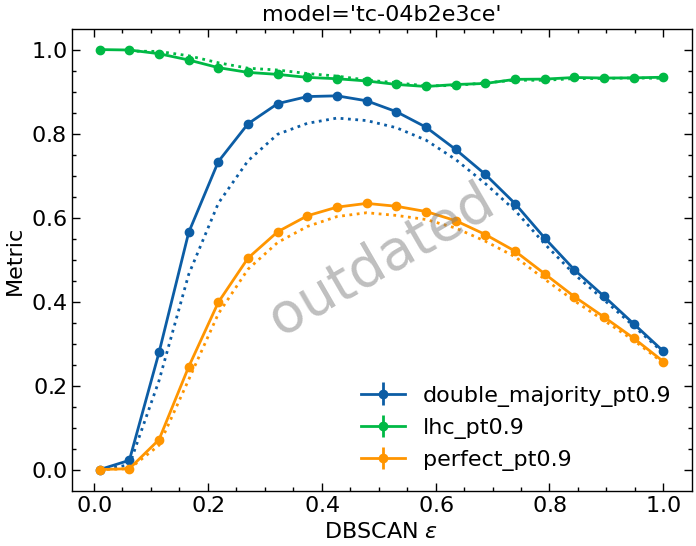

In [65]:
p = TracksVsDBSCANPlot(
    mean_df=lmodel.cluster_scanner.get_results().df_mean,
    model=chkpt_path.stem,
    watermark="outdated",
)
p.plot_var("double_majority_pt0.9")
p.plot_var("lhc_pt0.9")
p.plot_var("perfect_pt0.9")
p.ax.legend()

# vs pt and eta

In [143]:
h_dfs = []
c_dfs = []

In [144]:
# eyeballed
best_eps = 0.45
best_k = 1

In [146]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

lmodel.cluster_scanner = DBSCANPerformanceDetails(eps=best_eps, min_samples=best_k)

In [147]:
trainer = Trainer(accelerator="gpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [148]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[17:32:02] INFO: DataLoader will load 20 graphs (out of 1000 available).
[17:32:02] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v6/part_9/data29019_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gp

Validation: 0it [00:00, ?it/s]

TypeError: 'NoneType' object is not iterable

In [149]:
import itertools

In [151]:
h_dfs = lmodel.cluster_scanner.h_dfs
c_dfs = lmodel.cluster_scanner.c_dfs

In [152]:
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
import numpy as np

pts = np.array(np.linspace(0, 3, 10).tolist() + [5.0])
vs_pt = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)
etas = np.array(np.linspace(-6, 6, 10).tolist() + [6.0])
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)
print(len(pts), len(vs_pt), len(etas), len(vs_eta))

11 10 11 10


In [153]:
class PerformancePlot(Plot):
    def __init__(self, xs, df, var="pt", **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.xs = xs
        self.ax.set_xlabel(vm[var])
        self.ax.set_ylabel("Efficiency")

    def plot_var(
        self,
        var,
        color,
    ):
        self.ax.stairs(var, edges=self.xs, data=self.df, color=color)
        mids = (self.xs[:-1] + self.xs[1:]) / 2
        self.ax.errorbar(
            mids,
            var,
            yerr=f"{var}_std",
            ls="none",
            color=color,
            label=vm[var],
            data=self.df,
        )

    def add_blocked(self, a, b, label="Not trained for"):
        self.ax.axvspan(a, b, alpha=0.3, color="gray", label=label, linestyle="none")

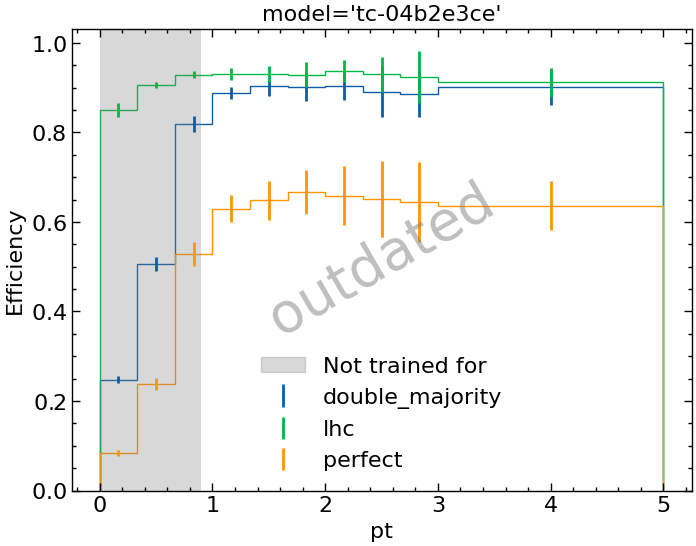

In [157]:
p = PerformancePlot(df=vs_pt, xs=pts, watermark="outdated", model=chkpt_path.stem)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.add_blocked(0, 0.9)
p.ax.legend()

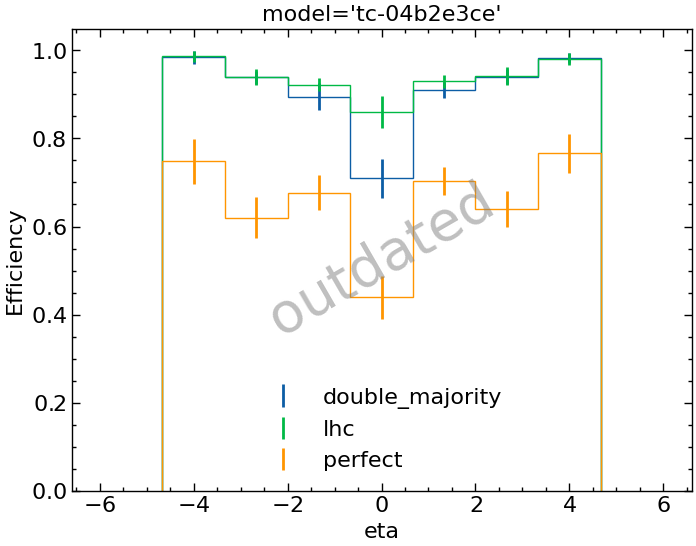

In [159]:
p = PerformancePlot(
    df=vs_eta, xs=etas, var="eta", watermark="outdated", model=chkpt_path.stem
)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.ax.legend()